# Self-Driving Car Engineer Nanodegree


## Project: Advanced Lane Finding
---
The goal of this project is to create a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car. 

The steps of the project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
 

### 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

The following code calculates the camera matrix and distortion coefficients using the images in the *"camera_cal"* folder. It was adopted from original Udacity [source](https://github.com/udacity/CarND-Camera-Calibration)

First we are using OpenCV library to extract object points `objpoints` and image points `imgpoints` needed for camera calibration.

Then, calibrate, calculate distortion coefficients. The camera calibration matrix and distortion coefficients are saved in file `dist_pickle.p`

In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
#%matplotlib qt
%matplotlib inline

# number of inside corners in x and y
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Keep filenames of image with not found corners to test camera calibration 
test_fnames = []
                 
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    # Read a file
    img = cv2.imread(fname)
    # Covert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # get filename
    filename = fname.split('\\')[-1]
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        write_name = 'camera_cal/'+'corners_'+filename
        cv2.imwrite(write_name, img)
        cv2.waitKey(500)
    else:
        test_fnames.append(fname)

#cv2.destroyAllWindows()

img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

print('Number of images with detected corners =', len(imgpoints))
print('Number of images with not detected corners =', len(test_fnames))

Number of images with detected corners = 17
Number of images with not detected corners = 3


Visualization utilities

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def plt_one(image, title = None):
    figure, ax = plt.subplots(figsize=(9, 6))
    ax.imshow(image)
    ax.set_title(title)
    plt.show()
    return figure
    
def plt_two(image_1, image_2, title_1 = None, title_2 = None):
    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(image_1)
    ax1.set_title(title_1, fontsize=30)
    ax2.imshow(image_2)
    ax2.set_title(title_2, fontsize=30)
    plt.show()
    return figure

A chessboard image with detected corners

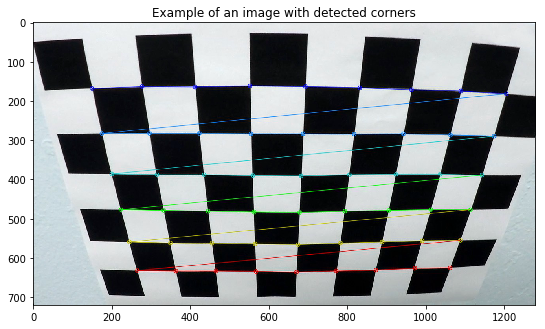

In [3]:
image = cv2.imread('camera_cal/corners_calibration2.jpg')

figure = plt_one(image, "Example of an image with detected corners")
plt.close(figure)    # close the figure

In 3 images the corners could not be detected because the number of cross points is not corresponding to the defined values of nx = 9 and ny = 6. I will use those images to test undistortion. 

### 2. Apply a distortion correction to raw images

First test a chessboard image

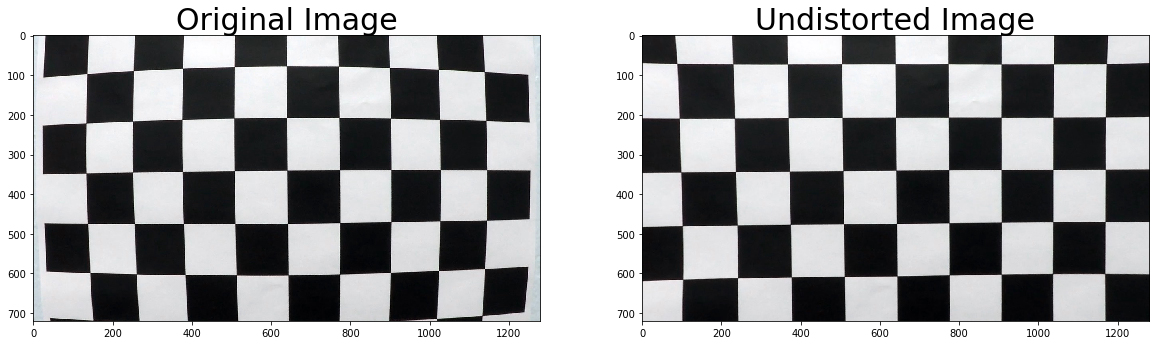

In [4]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def undistort_image(image, dist_pickle_fname):
    """
    The function reads in the saved camera matrix and distortion coefficients
    and undistort the input image
    Returns an undistorted image "undist"
    """    
    # Read in the saved camera matrix and distortion coefficients
    dist_pickle = pickle.load( open(dist_pickle_fname, "rb"))
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]        
    # Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Test on chessboard image
image = cv2.imread(test_fnames[0])
undist = undistort_image(image, "camera_cal/dist_pickle.p")

# Visualize undistortion
figure = plt_two(image, undist, 'Original Image', 'Undistorted Image')
figure.savefig('output_images/test_calibration.jpg')   # save the figure to file
plt.close(figure)    # close the figure

Now apply undistortion to raw images

### 3. Use color transforms, gradients, etc., to create a thresholded binary image

### 4. Apply a perspective transform to rectify binary image ("birds-eye view")

### 5. Detect lane pixels and fit to find the lane boundary

### 6. Determine the curvature of the lane and vehicle position with respect to center

### 7. Warp the detected lane boundaries back onto the original image

### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position


In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [6]:
import numpy as np
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    #result = proc_img_pipe(image)
    result = np.copy(image)
    
    return result    

In [7]:
#if os.path.exists('test_videos_output/'):
#    pass
#else:
#    os.mkdir('test_videos_output/')

white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [00:57<00:00, 23.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 59.4 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))